# Description

This notebook is meant to simulate stellar streams formed through star cluster accretion in a host potential (commonly the milky way MW).
It requires a config files, found in config folder, with particular cluster data (Pal_5 config fle is given as an example). User can create his own sts config file from the custom_config file in the same directory.
It is paired with simulation/data analysis python files found in Codes directory.
It switches beetween ICRS, galactic and (phi1, phi2) coordinate systems, depending of the user specification.

Required libraries to make it work are specified in the README file.

# Initialization

Import useful libraries and utilities, cluster_config file

In [1]:
###Libraries
#Mains
%matplotlib widget
# %matplotlib inline
import galpy.potential as gp
import galpy.df as gd #for streams PDF generation
import galpy.actionAngle as ga
from galpy.orbit import Orbit

#Utils
from importlib import reload
import pandas as pd
import sys
import yaml
import os
#Define user path
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u
import astropy.coordinates as ac
from astropy.table import Table
# import galpy.util.conversion as guconv
import galpy.util.coords as gucoord
import galpy.util.conversion as guconv
import gala.coordinates as gc #for great circle rotation
with ac.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = ac.Galactocentric()
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities

galcen_frame

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

In [2]:
##Load progenitor config file
# Path to the yaml config file in the 'config' folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
config_file = 'galstreams_Pal5_config.yaml'
config_path = os.path.join(base_dir, 'config', config_file)

# Load YAML and convert it to a DataFrame
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)

##Display cluster data
#current pose/velocity in ICRS
stream_data = pd.DataFrame(config_data)
# print(stream_data)
#only progenitor data is wanted for our simulation
progenitor = stream_data[4:].loc[:,["cluster","ra","dec","distance","pm_ra_cosdec","pm_dec","radial_velocity"]]
#["dec","dec_unit","distance","distance_unit","frame","pm_dec","pm_dec_unit","pm_ra_cosdec","pm_ra_cosdec_unit", "ra","ra_unit","radial_velocity","radial_velocity_unit"]
print(progenitor.values.tolist()[0])

['Pal5', 229.0, -0.124, 22.9, -2.296, -2.257, -58.7]



# Data generation with stellar stream simulation

The first goal is to generate stellar stream data thanks to a simulation.
User must choose between Mock and N-body stream simulation. 

Mock-stream simulation use particle spray technic with gala : it generates n stars outside the progenitor at each time step dt, only needing the progenitor orbit as phase-space data in the beginning. It runs faster but gives a simplified model of the stream, only providing main track stars.

N-body simulation simulate the entire developpement of the stream, taking each star as a massless body initialy in the progenitor, and getting ripped of due to tidal effects


"Mock" stream using galpy library.

**Step 1: System initialisation.**

The system includes initially a progenitor, an accreting host, perturbating DM subhalos (optional), and  a cluster host like dwarf galaxies (optional)

In [45]:
###Progenitor
#progenitor coord 
cluster = progenitor.values.tolist()[0][0]
prog_orbit = Orbit(progenitor.values.tolist()[0][1:], radec=True) #progenitor orbit instance. radec=True specify the frame used radec=ICRS


prog_mass = 2*10.**4.*u.Msun
prog_a = 4.*u.pc #scale radius of the plummer sphere
rc = 23*u.pc #progenitor radius
prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
prog_sigv = sutils.Plummer_sigv(prog_mass, prog_a, rc)/2.15 #velocity dispersion in original cluster. It's assumed that the velocity distribution is isotropic
print(prog_sigv)
t_disrupt = 4.5*u.Gyr #time of disruption of cluster, typically 4.5Gyr
# tdisrupt= guc.time_in_Gyr(V0,R0)

###Accreting host
### Usually Milky way potential
V0, R0= 245.6, 8.122 #scale parameters
vsun=[-12.9,245.6,7.78] #for streamdf, vxyz
mw_pot = gp.MWPotential2014
#mw_pot = gp.LogarithmicHaloPotential(normalize=1.,q=0.9) #is also often used


###Dark matter subhalo(s) and impact parameters
halo_mass = 1e5 *u.Msun #halo mass
halo_a =0.001*u.kpc
halo_pot = gp.NFWPotential(amp=halo_mass, a=halo_a)
v_halo = np.array([6.82200571,132.7700529,149.4174464]) #in km/s (vx,vy,vz)

b_impact = 0.#1 * u.pc
t_impact = 1* u.Gyr
angle_impact= 0.5
# print(0.88/guconv.time_in_Gyr(220,8))
###DG, initially hosting the cluster. Optional

0.36448724205723426 km / s


In [46]:
### Action angle setup - for action-angle space
aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=1.5)

**Step 2: Mock stream simulation**

In [47]:
###Modelise Non-perturbed stream using streamdf

#galpy generate stream lead and trail independently
s_lead = gd.streamdf(sigv = prog_sigv,
            progenitor=prog_orbit,
            pot=mw_pot,
            aA=aaisochrone,
            leading=True,
            nTrackChunks=26,
            ro = R0, #Distance scale for translation into internal units
            vsun=vsun,
            tdisrupt=t_disrupt)

s_trail = gd.streamdf(sigv = prog_sigv,
            progenitor=prog_orbit,
            pot=mw_pot,
            aA=aaisochrone,
            leading=False,
            nTrackChunks=26,
            ro = R0, #Distance scale for translation into internal units
            vsun=vsun,
            tdisrupt=t_disrupt)


KeyboardInterrupt: Orbit integration interrupted by CTRL-C (SIGINT)

In [48]:
### Perturbed stream, if impact angle <0, trail perturbation, if angle>0, lead perturbation
perturbed_stream = gd.streamgapdf(sigv=prog_sigv, #Radial velocity dispersion of the progenitor
                        progenitor=prog_orbit, #Progenitor orbit instance
                        pot = mw_pot, #accreting host potential
                        aA = aaisochrone, #ActionAngle instance used to convert (x,v) to actions. Generally a actionAngleIsochroneApprox instance.
                        tdisrupt = t_disrupt,#  Time since start of disruption
                        leading = True, #Choice of modelling the leading part (=True) or the trailing part (=False) of the stream
                        #deltaAngleTrack=3, #Angle to estimate the stream track over (rad)
                        nTrackChunks = 26, #Number of chunks to divide the progenitor track in
                        # nTrackIterations = 1, #Number of iterations to perform when establishing the track
                        vsun=vsun,
                        ro = R0, #Distance scale for translation into internal units
                        # vo = V0, #Velocity scale for translation into internal units
                        impactb = b_impact, #Impact parameter between halo and streams
                        subhalovel = v_halo, # Velocity of the subhalo
                        timpact = t_impact, # Time of impact
                        impact_angle = angle_impact, #Angle offset from progenitor at which the impact occurred
                        subhalopot = halo_pot,# Gravitational potential of the subhalo
                        higherorderTrack = False, #calculate the track using higher-order terms
                        )



/home/hallouin/miniconda3/envs/streams/lib/python3.13/site-packages/galpy/df/streamgapdf.py:1554: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(_a_integrand, -1.0, 1.0, args=(y, b, w, pot, i))[0]



In [49]:
###Generating stars along the PDF. With this method, stars are generated after the stream generation
n_stars = 10000 #number of stars along the leading(trailing) part of the stream
np.random.seed(4439)
ps_stars = perturbed_stream.sample(n_stars, xy=True)*R0 #ps for perturbed stream, s for stream #*R0 because galpy renormalization
np.random.seed(4439)
s_lead_stars = s_lead.sample(n_stars, xy=True)*R0
np.random.seed(4439)
s_trail_stars = s_trail.sample(n_stars, xy=True)*R0 #ps for non-perturbed stream, s for stream
# s_lead_stars = stream_c24_lead.sample(n_stars)

**Step 3: conversion into observer coordinate system and plot**

In simulation as in data analysis, the main goal of the study is to compute the star density variation along the stream. Hence we need to convert star positions in an appropriate and more physical frame. We'll use icrs then (Phi1,Phi2) coordinate system, where phi1 is the angle along the stream (longitude-like) and Phi2 the angle perpendicular to the stream (latitude-like), as seen from Earth. We define (0,0) as the progenitor position in the sky.

In [50]:
### sampled stars positions
#Extract positions from sampled stars, in xyz galactocentric
X_ps, Y_ps, Z_ps = np.array(ps_stars[:3])* u.kpc# apply np.array()* u.kpc if needed
X_s_trail, Y_s_trail, Z_s_trail = np.array(s_trail_stars[:3])* u.kpc
X_s_lead, Y_s_lead, Z_s_lead = np.array(s_lead_stars[:3])* u.kpc
X_ps,X_s_trail,X_s_lead = -X_ps,-X_s_trail,-X_s_lead #galpy use lefthanded frame, we use righthanded x-> -x
#apply cartesian galactocentric frame to these positions

with ac.galactocentric_frame_defaults.set("v4.0"):  # Use latest MW parameters
    galcen_ps = ac.Galactocentric(x=X_ps, y=Y_ps, z=Z_ps)
    galcen_s_trail = ac.Galactocentric(x=X_s_trail, y=Y_s_trail, z=Z_s_trail)
    galcen_s_lead = ac.Galactocentric(x=X_s_lead, y=Y_s_lead, z=Z_s_lead)


#convert galcen into icrs (as seen from observer)
icrs_ps = galcen_ps.transform_to(ac.ICRS())
icrs_s_trail = galcen_s_trail.transform_to(ac.ICRS())
icrs_s_lead = galcen_s_lead.transform_to(ac.ICRS())

ra_ps, dec_ps, dist_ps, = icrs_ps.T.ra.degree, icrs_ps.T.dec.degree, icrs_ps.T.distance.kpc #ra,dec,distance
ra_s_trail, dec_s_trail, dist_s_trail = icrs_s_trail.T.ra.degree, icrs_s_trail.T.dec.degree, icrs_s_trail.T.distance.kpc
ra_s_lead, dec_s_lead, dist_s_lead = icrs_s_lead.T.ra.degree, icrs_s_lead.T.dec.degree, icrs_s_lead.T.distance.kpc
icrs_s_lead

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    [(222.68144829, -6.67086607, 21.16551183),
     (224.38462557, -4.71552716, 21.76313068),
     (220.46947083, -9.50096069, 20.26719643), ...,
     (220.73388614, -9.15244891, 20.31456788),
     (222.57804996, -6.66248959, 21.21069675),
     (227.97932841, -1.2199059 , 22.83150428)]>

(7.86390455, 0.22748727, 16.41622487) kpc
/tmp/ipykernel_65840/82535270.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2 = plt.figure()



Text(0, 0.5, 'Y')

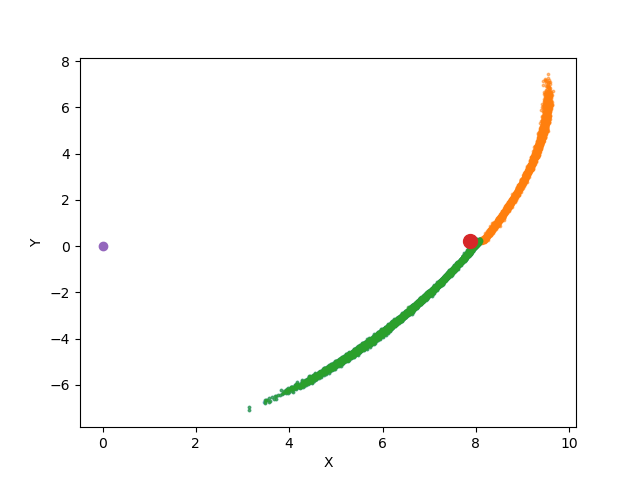

In [51]:
#3D representation
#Cluster, local background potential
c = ac.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
c_gc = c.transform_to(galcen_frame)
print(c_gc.cartesian)
fig2 = plt.figure()
ax2 = fig2.add_subplot()

ax2.scatter(X_ps, Y_ps, alpha=0.5, s=3)#sts
ax2.scatter(X_s_trail, Y_s_trail, alpha=0.5, s=3)
ax2.scatter(X_s_lead, Y_s_lead, alpha=0.5, s=3)
ax2.scatter(c_gc.cartesian.x,c_gc.cartesian.y,s=100)#progenitor
ax2.scatter(0,0)#galatic center

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
# ax2.set_zlabel('Z')

(7.86390455, 0.22748727, 16.41622487) kpc


Text(0.5, 0, 'Z')

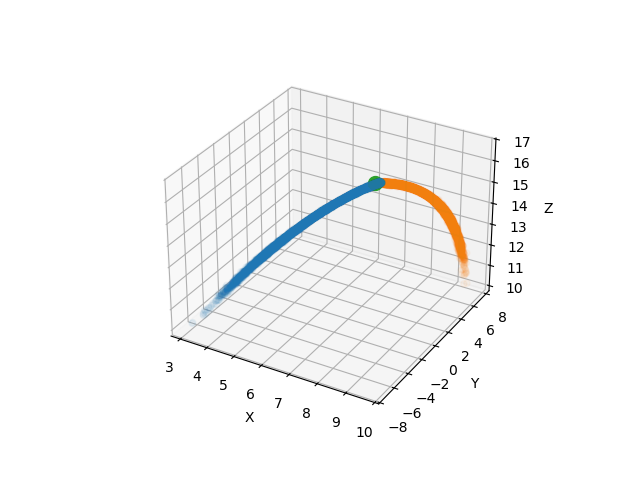

In [52]:
#3D representation
#Cluster, local background potential
c = ac.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
c_gc = c.transform_to(galcen_frame)
print(c_gc.cartesian)
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

ax3.scatter(X_ps, Y_ps, Z_ps, alpha=0.05)#sts
ax3.scatter(X_s_trail, Y_s_trail, Z_s_lead, alpha=0.05)
ax3.scatter(c_gc.cartesian.x,c_gc.cartesian.y, c_gc.cartesian.z,s=100)#progenitor
# ax3.scatter(0,0,0)#galatic center

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

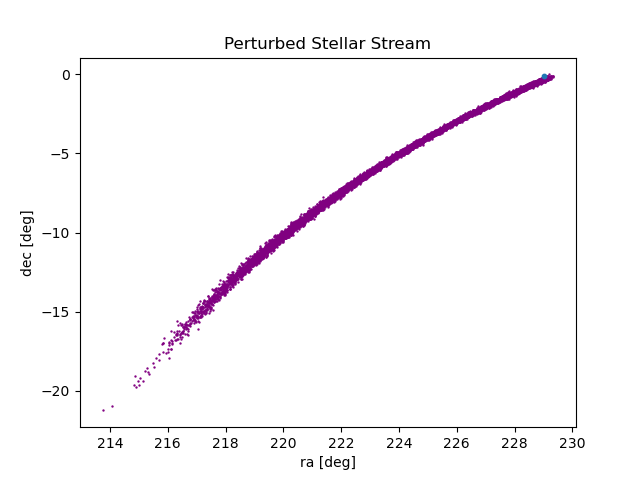

[229.0]

In [60]:
### plot the track in the radec frame to see how it would appears from an observer on earth
ra_prog, dec_prog = progenitor.loc[:,['ra']].values.tolist()[0], progenitor.loc[:,['dec']].values.tolist()[0]
# ra_prog, dec_prog = radec_prog
plt.figure()
plt.scatter(ra_ps, dec_ps, s=0.5, c='purple')
# plt.scatter(ra_s_trail, dec_s_trail, s=0.5)
# plt.scatter(ra_s_lead, dec_s_lead, s=0.5)
plt.scatter(ra_prog, dec_prog, s=10)#progenitor

plt.xlabel("ra [deg]")
plt.ylabel("dec [deg]")
plt.title("Perturbed Stellar Stream")
plt.show()
ra_prog

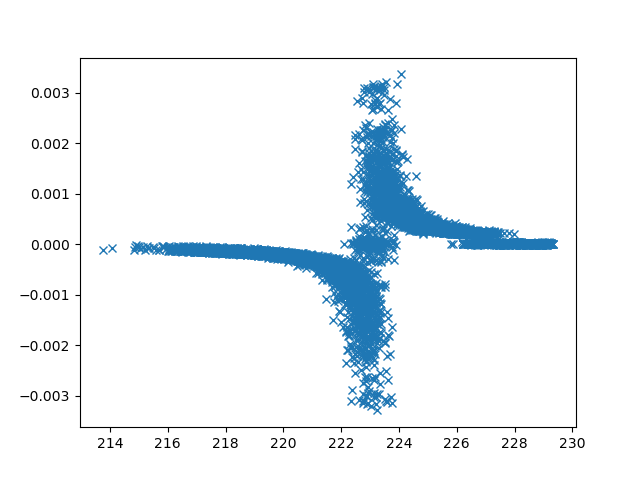

In [55]:
### Plot difference between perturbed an dnon perturbed tXil vs non-prtutbed tXil
plt.figure()
plt.plot(ra_s_lead, ra_ps-ra_s_lead, 'x')
plt.show()

In [56]:
### finally convert into Phi1,Phi2 frame
##this is a little bit tricky, since we cant the coordinate Phi1=0 follow the track, here we have 2 options:
# - Phi1=0 exactly follow the progenitor orbit. It means that we need to define a curviline abciss defined by the progenitor orbit
# - Phi1=0 is defined by the line which have the best fit with stellar streams stars, passing by the progenitor pos
#we choose for the moment option 2  

##using gala module for setting stream coordinate frame
pole1 = ac.SkyCoord(ra=ra_prog*u.deg, dec=dec_prog*u.deg)
pole2 = ac.SkyCoord(ra=235*u.deg, dec=4*u.deg)
stream_frame = gc.GreatCircleICRSFrame.from_endpoints(pole1, pole2, origin=pole1)

#convert
radec_ps_c = ac.SkyCoord(ra=ra_ps*u.deg, dec=dec_ps*u.deg) #in astropy coord for conversion
radec_s_trail_c = ac.SkyCoord(ra=ra_ps*u.deg, dec=dec_ps*u.deg)
radec_s_lead_c = ac.SkyCoord(ra=ra_s_lead*u.deg, dec=dec_s_lead*u.deg)
icrs_ps 
phi12_ps = radec_ps_c.transform_to(stream_frame)
phi12_s_lead = radec_s_lead_c.transform_to(stream_frame)
phi12_s_trail = radec_s_trail_c.transform_to(stream_frame)

In [57]:
#Create a total stellar stream with a perturbed trail (lead) and an unperturbed lead (trail)
sts_phi1 = np.concatenate((phi12_ps.phi1, phi12_s_lead.phi1))
sts_phi2 = np.concatenate((phi12_ps.phi2, phi12_s_lead.phi2))

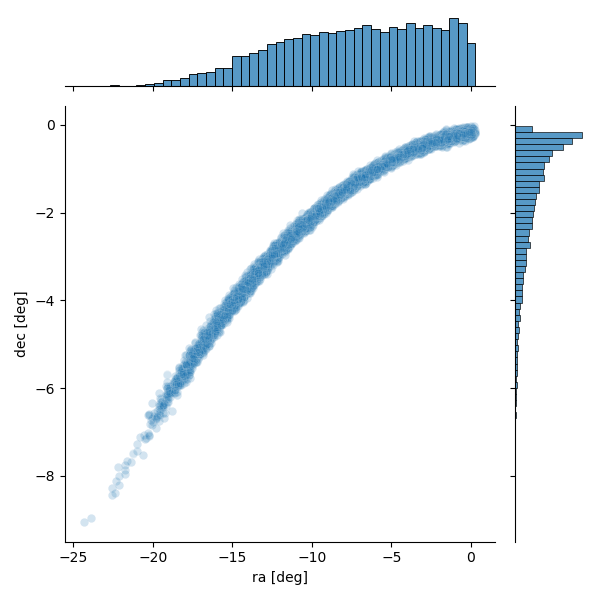

In [58]:
### plot the track in the radec frame to see how it would appears in the stream frame
# plt.figure()
# plt.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
# plt.scatter(phi12_s_trail.phi1, phi12_s_trail.phi2, s=0.5)
# plt.scatter(ra_prog, dec_prog, s=10)
# plt.xlabel("ra [deg]")
# plt.ylabel("dec [deg]")
# plt.title("Perturbed Stellar Stream")
# plt.show()

sns.jointplot(x=sts_phi1, y=sts_phi2, alpha=0.1)
# ax1.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
plt.xlabel("ra [deg]")
plt.ylabel("dec [deg]")

plt.tight_layout()



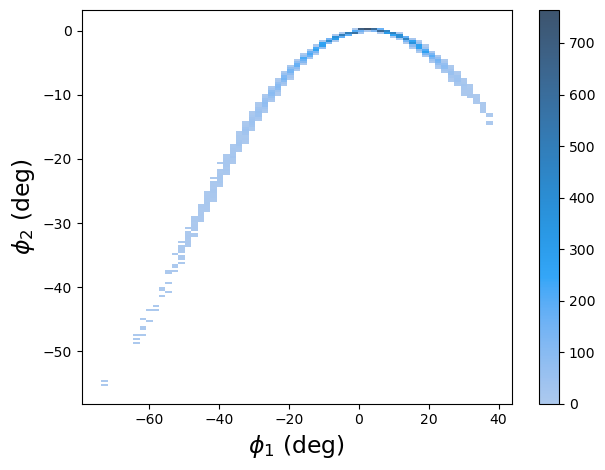

In [21]:
plt.figure()
hist2D = sns.histplot(x=sts_phi1,y=sts_phi2,cbar=True)
plt.xlabel(r'$\phi_1$ (deg)',fontsize=17)
plt.ylabel(r'$\phi_2$ (deg)',fontsize=17)
plt.tight_layout()


In [22]:
#Save generated data in the format (Phi1, Phi2)

**Step 4: magnitude sampling**

Optional. Gives gri magnitude to stars, depending on isochrone properties and distance modulus. Same class as from stream_sim magnitude sampler



In [23]:
#Save generated data in the format (Phi1, Phi2)

import numpy as np
import astropy.coordinates as coord
import astropy.units as u
import warnings
from ugali.isochrone import factory

class IsochroneModel:
    """ Isochrone model for assigning magnitudes to stars. """
    
    def __init__(self, config):
        self.config = config
        self.create_isochrone(config)
    
    def create_isochrone(self, config):
        """Create the isochrone model from the configuration."""
        self.iso = factory(**config)
        self.iso.params['distance_modulus'].set_bounds([0, 50])

        if 'distance_modulus' in config:
            warnings.warn('Use the "distance_modulus" section of the config file instead.')
        self.iso.distance_modulus = 0  # Default value
        
    def _dist_to_modulus(self, distance):
        """Convert physical distances (kpc) into distance modulus."""
        if distance is None:
            return 0
        elif np.all(distance == 0):
            warnings.warn("Distances are 0; setting distance modulus to 0.")
            return 0
        else:
            return 5 * np.log10(distance * 1000) - 5  # Convert kpc to pc

    def sample_magnitudes(self, icrs_list):
        """Assign magnitudes (g, r) to stars based on their distance."""
        distances = icrs_list.distance.to(u.kpc).value  # Extract distances in kpc
        distance_moduli = self._dist_to_modulus(distances)  # Compute distance modulus

        # Sample magnitudes for each star
        mag_g, mag_r = self.sample(len(distances), distance_moduli)

        return mag_g, mag_r

    def sample(self, nstars, distance_modulus):
        """Sample magnitudes using the isochrone."""
        stellar_mass = nstars * self.iso.stellar_mass()

        if np.isscalar(distance_modulus):
            mag_g, mag_r = self.iso.simulate(stellar_mass, distance_modulus=self.iso.distance_modulus)
            mag_g, mag_r = [mag + distance_modulus for mag in (mag_g, mag_r)]
        else:
            mag_g, mag_r = self.iso.simulate(stellar_mass, distance_modulus=self.iso.distance_modulus)
            mag_g, mag_r = [mag + distance_modulus for mag in (mag_g, mag_r)]

        return mag_g, mag_r

config = {
    "name": "Bressan2012",
    "survey": "lsst",
    "age": 12.0,
    "z": 0.0006,
    "band_1": "g",
    "band_2": "r",
    "band_1_detection": True
}

isochrone_model = IsochroneModel(config)

# Example: Assign magnitudes to each star list
mag_g_ps, mag_r_ps = isochrone_model.sample_magnitudes(icrs_ps)
mag_g_s_trail, mag_r_s_trail = isochrone_model.sample_magnitudes(icrs_s_trail)
mag_g_s_lead, mag_r_s_lead = isochrone_model.sample_magnitudes(icrs_s_lead)


# print("First 5 stars (g, r) in icrs_ps:")
# for i in range(5):
#     print(f"Star {i+1}: g = {mag_g_ps[i]:.2f}, r = {mag_r_ps[i]:.2f}")


In [24]:
from astropy.table import Table

# Define the directory path
data_dir = "../data/"  # Relative path from "notebooks/"
os.makedirs(data_dir, exist_ok=True)  # Create directory if it doesn't exist

def save_star_data(icrs_list, mag_g, mag_r, filename):
    """Save RA, Dec, Distance, mag_g, mag_r to a CSV file in 'data/' directory."""
    
    # Create Astropy table
    table = Table(
        data=[
            icrs_list.ra.deg,         # RA in degrees
            icrs_list.dec.deg,        # Dec in degrees
            icrs_list.distance.kpc,   # Distance in kpc
            mag_g,                    # g-band magnitude
            mag_r                     # r-band magnitude
        ],
        names=["ra", "dec", "dist", "mag_g", "mag_r"]
    )

    # Save to CSV
    filepath = os.path.join(data_dir, filename)
    table.write(filepath, format="csv", overwrite=True)
    print(f"Saved: {filepath}")

# Save s_trail separately
#save_star_data(icrs_s_trail, mag_g_s_trail, mag_r_s_trail, "icrs_s_trail.csv")

# Concatenate icrs_ps and icrs_s_lead into one file
from astropy.coordinates import concatenate

Pal5_perturbed = concatenate([icrs_ps, icrs_s_lead])
mag_g_combined = np.concatenate([mag_g_ps, mag_g_s_lead])
mag_r_combined = np.concatenate([mag_r_ps, mag_r_s_lead])

save_star_data(Pal5_perturbed, mag_g_combined, mag_r_combined, f"{cluster}_stars.csv")

Saved: ../data/Pal5_stars.csv


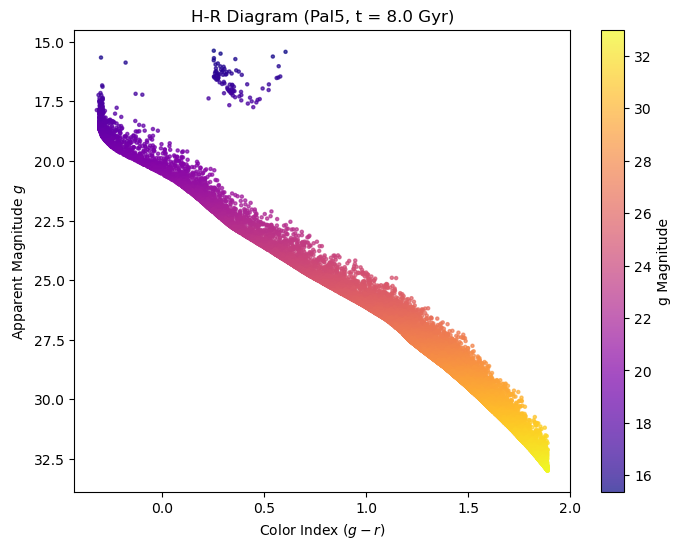

In [25]:
from astropy.table import Table

# Load the data
data_file = f"../data/{cluster}_stars.csv"  # Path to the saved CSV
table = Table.read(data_file, format="csv")

# Compute the color index (g-r)
color_index = table["mag_g"] - table["mag_r"]

# H-R diagram (Absolute mag vs. Color index)
plt.figure(figsize=(8, 6))
plt.scatter(color_index, table["mag_g"], s=5, c=table["mag_g"], cmap="plasma", alpha=0.7)

# Flip the y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels
plt.xlabel(r"Color Index $(g - r)$")
plt.ylabel(r"Apparent Magnitude $g$")
plt.title(f"H-R Diagram (Pal5, t = {t_disrupt})")

# Colorbar
plt.colorbar(label="g Magnitude")

# Show the plot
plt.show()


# Stellar stream Density

Now that we got star distribution along the stream, we are interested in computing the density along the track. To do so we define a function that count the number of star in a given box. The density is defined as follow: Phi1 increase linearly in the range [Phimin,Phimax]. To each interval [Phi1-deltaPhi1,Phi1+deltaPhi1] is assigned a mid track width value Phi2. It is sum the number of stars in the column of witdh w corresponding to Phi1[i], where w is the sum of each bin size in the Phi2 direction, i.e. the width of the track.

In [26]:
#ensure to have a stream in the shape [[star1], [star2], ...] to agree with real star data.
stream_phi12 = np.array([sts_phi1.degree, sts_phi2.degree]).T
stream_phi12
#to do: convert with pd data frame [Phi1, Phi2, pmPhi1, pmPhi2, magr,...]

array([[ 14.62385734,  -1.59834969],
       [ 10.50146922,  -0.46293722],
       [ 19.47399088,  -3.31916571],
       ...,
       [-24.36561801,  -9.46567811],
       [-17.4373939 ,  -5.19983402],
       [ -2.72126598,  -0.46214294]], shape=(20000, 2))

In [27]:
from astropy.table import Table
import numpy as np
from scipy.optimize import least_squares

def gaussian(params, x):
    A, mu, sigma = params
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

def residuals(params, x, y):
    return gaussian(params, x) - y

def stream_density(stream, delta_phi1=0.02, max_fev=5000):
    phi1_stars = stream.T[0]
    phi2_stars = stream.T[1]

    phi1_min = np.min(phi1_stars) + delta_phi1
    phi1_max = np.max(phi1_stars) - delta_phi1
    phi2_min = np.min(phi2_stars)
    phi2_max = np.max(phi2_stars)
    nbins1 = int((phi1_max - phi1_min) / delta_phi1)

    phi1_vals, phi2_vals, nstars_vals, width_vals = [], [], [], []

    for phi1_t in np.arange(phi1_min, phi1_max, delta_phi1):
        width = 0.2
        mask_phi1 = (np.abs(phi1_stars - phi1_t) < width)
        selected_phi2 = phi2_stars[mask_phi1]

        if len(selected_phi2) > 0:
            hist_nstars, bin_phi2 = np.histogram(selected_phi2, bins=1000, range=(phi2_min, phi2_max))
            max_bin_idx = np.argmax(hist_nstars)
            max_phi2 = (bin_phi2[max_bin_idx] + bin_phi2[max_bin_idx + 1]) / 2

            # Initial guess
            A0 = max(hist_nstars)
            mu0 = max_phi2
            sigma0 = 1.0
            p0 = [A0, mu0, sigma0]

            # Fit using least_squares
            result = least_squares(
                residuals, p0, args=(bin_phi2[:-1], hist_nstars),
                max_nfev=max_fev
            )

            if result.success and result.nfev < max_fev and result.x[0]<100:
                A_fit, mu_fit, sigma_fit = result.x
                phi1_vals.append(phi1_t)
                phi2_vals.append(mu_fit)
                nstars_vals.append(A_fit)
                width_vals.append(sigma_fit)
            else:
                # You can log or skip silently
                continue

    density_table = Table([phi1_vals, phi2_vals, nstars_vals, width_vals],
                          names=('phi1', 'phi2', 'nstars', 'width'))
    return density_table

stream_erkal = stream_density(stream_phi12, delta_phi1=0.1)


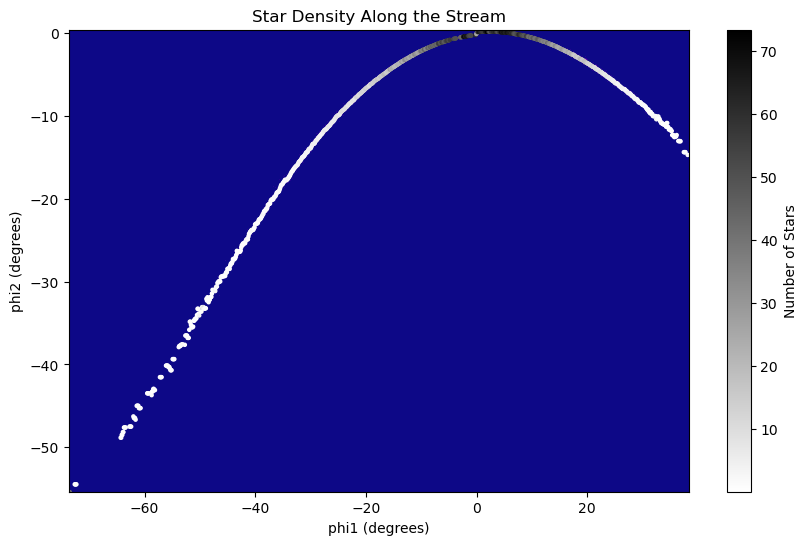

In [28]:
# Plot the density in the frame (scatter plot of phi1, phi2 values)
plt.figure(figsize=(10, 6))
plt.hist2d(stream_phi12.T[0], stream_phi12.T[1], bins=[1000, 1000], cmap='plasma')
plt.scatter(stream_erkal['phi1'], stream_erkal['phi2'], c=stream_erkal['nstars'], cmap='gist_yarg', s=5)
plt.colorbar(label='Number of Stars')
plt.xlabel('phi1 (degrees)')
plt.ylabel('phi2 (degrees)')
plt.title('Star Density Along the Stream')
# plt.grid(True)
plt.show()

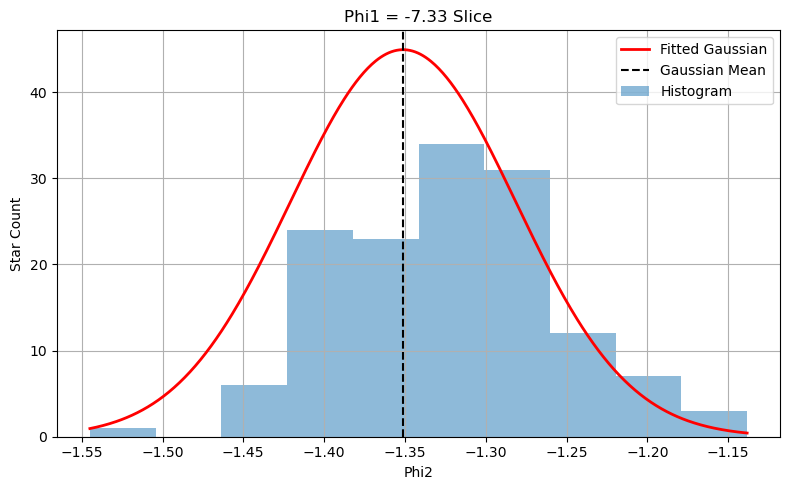

In [29]:
###Just cheking if the gaussian fit works
i = 520  # index in stream_erkal

# Center Phi1 value and width of the bin
phi1_center = stream_erkal['phi1'][i]
phi1_width = 0.2

# Select stars in that Phi1 slice
mask = np.abs(stream_phi12.T[0] - phi1_center) < phi1_width
phi2_slice = stream_phi12.T[1][mask]

# Make histogram
phi2_min, phi2_max = np.min(phi2_slice), np.max(phi2_slice)
hist, bins = np.histogram(phi2_slice, bins=10, range=(phi2_min, phi2_max))
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Get fitted parameters
A_fit = stream_erkal['nstars'][i]
mu_fit = stream_erkal['phi2'][i]
sigma_fit = stream_erkal['width'][i]

# Gaussian for comparison
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

phi2_fine = np.linspace(phi2_min, phi2_max, 500)
gauss_fit = gaussian(phi2_fine, A_fit, mu_fit, sigma_fit)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist, width=(bins[1] - bins[0]), alpha=0.5, label="Histogram")
plt.plot(phi2_fine, gauss_fit, 'r-', linewidth=2, label="Fitted Gaussian")
plt.axvline(mu_fit, color='k', linestyle='--', label="Gaussian Mean")
plt.title(f'Phi1 = {phi1_center:.2f} Slice')
plt.xlabel("Phi2")
plt.ylabel("Star Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
### Save data file to csv
# sys.path.append(os.path.abspath('../'))
# base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))


stream_erkal.write(f'{base_dir}/data/hall_2024_{cluster}_input.csv', format='csv', overwrite=True)